<a href="https://colab.research.google.com/github/ellagattis/hpc/blob/main/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2



## Part 1

Task is to extend this code to deal with larger numbers of sources.

* Create threadblocks of size 16 x 32 which are responsible for 16 targets and 32 sources. Each threadblock now evaluates its own local result, which is an array of size 16 and writes the result back into global memory

* Then create a second kernel that runs over the intermediate results and sums up the intermediate results into the final sum

* We assume that we have m targets and n sources
* We therefore need to create a grid of $(\ell, p)$ thread blocks with $\ell = (m+15) / 16$ and $p = (n + 31) / 32$, where the division is to be understood as integer division.

* Use the CUDA memory transfer functions to copy the sources and targets to the compute device.

* On the compute device create an array for the intermediate results that is of size (m, p).

* Launch threadblocks that evaluate the partial sum for 16 targets and 32 sources at a time and store the results in the corresponding part of the (m, p) array.

* Then launch a summation kernel of m threads, where each thread sums up the p numbers in its row of the intermediate array (m, p) and store into a result array of dimension m.

* Finally, copy the end result back to the CPU and return to the user.
* Be careful with memory transfers. We do not want to transfer the intermediate array back and forth between CPU and GPU, so you need to manually create the device arrays and launch the CUDA kernels with the device arrays.

* Demonstrate that your code is correct by validating it with the Python Numba implementation that we have written and show that up to single precision accuracy your result agrees with this implementation. You will lose significant marks if you do not validate your code as without validation the correctness is not demonstrated.

* Show benchmark results and experiment with how many sources and targets you can evaluate in a reasonable time (around a few seconds of runtime). Also, separately demonstrate benchmark times for the memory transfers from the CPU to the GPU and back, and benchmarks for the actual computation on the device.

In [ ]:
import numpy as np
import numba
import math
from numba import cuda
sigma = .1

In [ ]:
#set up sources and targets - copied from notes
npoints = 400 #number of target points in one dimension
#should be able to change this to a large number
nsources = 50

plot_grid = np.mgrid[0:1:npoints * 1j, 0:1:npoints * 1j]

targets_xy = np.vstack((plot_grid[0].ravel(),
                        plot_grid[1].ravel(),
                        np.zeros(plot_grid[0].size))).T
targets_xz = np.vstack((plot_grid[0].ravel(),
                        np.zeros(plot_grid[0].size),
                        plot_grid[1].ravel())).T
targets_yz = np.vstack((np.zeros(plot_grid[0].size),
                       plot_grid[0].ravel(),
                       plot_grid[1].ravel())).T

targets = np.vstack((targets_xy, targets_xz, targets_yz))

rand = np.random.RandomState(0)

# We are picking random sources
sources = rand.rand(nsources, 3)

In [ ]:
#function to visualize results - copied from notes
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

plt.rcParams["font.size"] = 16

weights = rand.rand(len(sources))

def visualize(result, npoints):
    """A helper function for visualization"""
    
    result_xy = result[: npoints * npoints].reshape(npoints, npoints).T
    result_xz = result[npoints * npoints : 2 * npoints * npoints].reshape(npoints, npoints).T
    result_yz = result[2 * npoints * npoints:].reshape(npoints, npoints).T

    fig = plt.figure(figsize=(20, 20))    

    ax = fig.add_subplot(1, 3, 1)   
    im = ax.imshow(result_xy, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax = fig.add_subplot(1, 3, 2)   
    im = ax.imshow(result_xz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('z')

    ax = fig.add_subplot(1, 3, 3)   
    im = ax.imshow(result_yz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('y')
    ax.set_ylabel('z')

In [ ]:
@cuda.jit
def rbf_evaluation_cuda(sources, targets, weights, intermediate_result):
    """
    Evaluate the RBF sum using CUDA parallelization
    Each thread computes a component of the result
    """
    local_result = cuda.shared.array((SX, SY), numba.float32) # 2d array length 16 (targets) width 32 (sources)
    local_targets = cuda.shared.array((SX, 3), numba.float32) # 2d array length 16 (targets at a time) width 3
    local_sources = cuda.shared.array((SY, 3), numba.float32) # 2d array length 32 (sources at a time) width 3
    local_weights = cuda.shared.array((SY), numba.float32) # 1d array length 32 (sources at a time)
    
    #local target position
    tx = cuda.threadIdx.x
    #local source position
    ty = cuda.threadIdx.y
    
    #global matrix position
    px, py = cuda.grid(2)
    
    if px >= targets.shape[0]:
        return

    # At first we are loading ALL the targets into the shared memory
    # We use only the first column of threads to do this. 
    if ty == 0:
        for index in range(3):
            local_targets[tx, index] = targets[px, index]
    
    # We are now loading ALL the sources and weights.
    # We only require the first row of threads to do this.
    if tx == 0:
        for index in range(3):
            local_sources[ty, index] = sources[py, index]
        local_weights[ty] = weights[py] #change to py - need global index
        
    # Let us now sync all threads
    cuda.syncthreads()
    
    # Now compute the interactions
    squared_diff = numba.float32(0)
    
    for index in range(3):
        squared_diff += (local_targets[tx, index] - local_sources[ty, index])**2
    local_result[tx, ty] = math.exp(-squared_diff / ( numba.float32(2) * numba.float32(sigma)**2)) * local_weights[ty]
    
    cuda.syncthreads()
    
    # Now sum up all the local results
    if ty == 0:
        res = numba.float32(0)
        for index in range(SY):
            res += local_result[tx, index]
        intermediate_result[px, cuda.blockIdx.y] = res    

This function works by splitting the array of m targets and n sources which is written the global memory into l,p threadblocks of 32x16 in shared memory, each containing 32 sources and 16 targets. Rather than SY being = nsources it is now = 32 so there are 32 sources evaluated in any one block.  It then finds the interaction of the sources with the targets in each block by iterating in the p direction to produce l,p blocks of 16x1 dimension each. It then recombines these results into an array of dimension (m,p) which is the intermediate result. This speeds up computation for higher numbers of sources. Previously the m,n array of targets and sources was split into l blocks of 16 targets and all n sources, and then the interaction of each of the 16 targets with all the sources was calculated. This meant all source points were accessed at once, which is a lot of memory for larger number of sources. Our version only loads a small subset of sources at once. This reduces the global memory access by splitting the targets and sources into small shared blocks which can be executed in parallel before being summed. The second summation kernel then splits the m, p intermediate array into m threads of length p, and finds interaction of all p in each thread- equivalent to what the rbf function from the lecture notes did, to produce a final result array of size (m,1). By using this threadblock structure, we reduce the number of global memory accesses since sources is now only read targets.shape[1] / TPB times and targets is read sources.shape[0] / TPB times.

In [ ]:
@cuda.jit
def summation_kernel(intermediate, result):
  """
  sums over intermediate array of shape (m,p) by splitting into m threads of length p
  and summing over all p in each thread for result array of shape (m,1)
  """
  #global matrix position
  px, py = cuda.grid(2)
  resultsum = numba.float32(0)
  for index in range(p):
      resultsum += intermediate[px, index]
  result[px] = resultsum

In [ ]:
#set up values
m = len(targets)
n = nsources

SX = 16 # 16 targets at a time (threadblock size in target direction)
SY = 32 # 32 sources at a time (threadblock size in source direction)

#threadblock dimensions will be (l,p)
l = (m+15) // 16
p = (n+31) // 32

#we want sources, targets, and intermediate results all to be written to global memory
sources_global_mem = cuda.to_device(sources)
targets_global_mem = cuda.to_device(targets)
int_results_global_mem = cuda.device_array((m, p)) # [m x p] intermediate result array

#create an array with the same number of entries as there are targets in the global memory to write the results into
result_global_mem = cuda.device_array(m)

#execute all calculations with the global memory arrays
rbf_evaluation_cuda[(l,p), (SX, SY)](sources_global_mem, targets_global_mem, weights.astype('float32'), int_results_global_mem)
summation_kernel[m,1](int_results_global_mem, result_global_mem)

#now copy the final result fromthe global memory to the CPU
res = result_global_mem.copy_to_host()

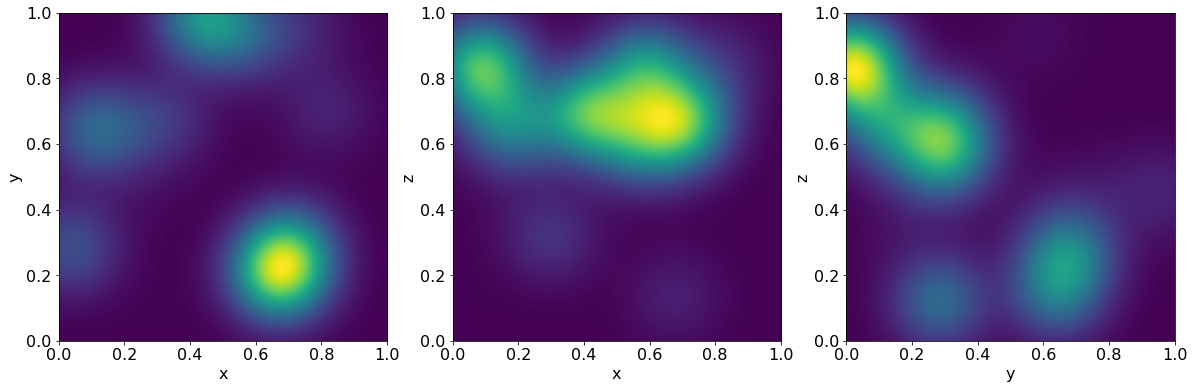

In [ ]:
visualize(res, npoints)

In [ ]:
%%timeit 
rbf_evaluation_cuda[(l, p), (SX, SY)](sources.astype('float32'), targets.astype('float32'), weights.astype('float32'), int_results_global_mem)
summation_kernel[m,1](int_results_global_mem, result_global_mem)

The slowest run took 26.60 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 12.3 ms per loop


In [ ]:
#parallel CPU implementation for comparison
@numba.njit(parallel=True)
def rbf_evaluation(sources, targets, weights, result):
    """Evaluate the RBF sum."""
    
    n = len(sources)
    m = len(targets)
        
    result[:] = 0
    for index in numba.prange(m):
        result[index] = np.sum(np.exp(-np.sum(np.abs(targets[index] - sources)**2, axis=1) / (2 * sigma**2)) * weights)

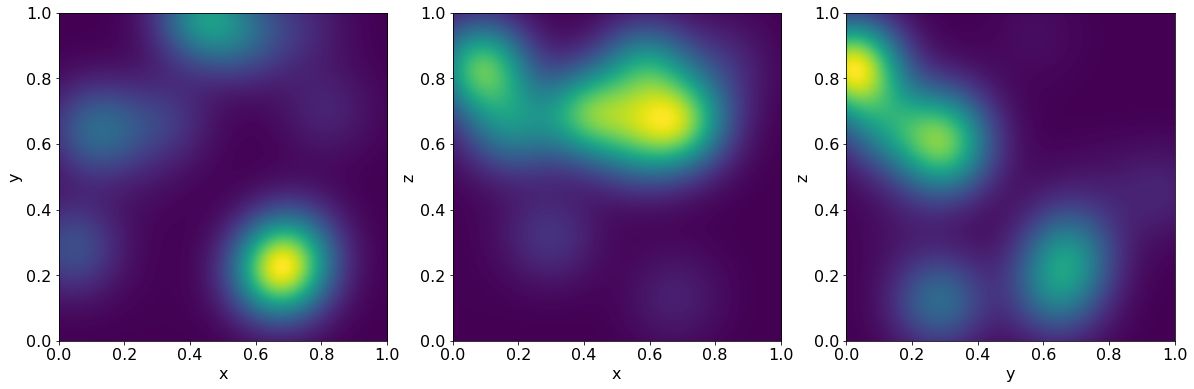

In [ ]:
result = np.zeros(len(targets), dtype=np.float64) #intialise array to write to
rbf_evaluation(sources, targets, weights, result) #implement CPU version
visualize(result, npoints)

In [ ]:
%timeit rbf_evaluation(sources, targets, weights, result)

1 loop, best of 3: 651 ms per loop


In [ ]:
rel_error = np.linalg.norm(res - result, np.inf) / np.linalg.norm(result, np.inf)
print(f"Error: {round(rel_error, 2)}.")

Error: 0.0.


The error up to single precision accuracy is zero, showing that both versions give the same result. For 400 targets and 50 sources, the GPU version took 11.9 ms per loop, and the CPU version 594 ms per loop- a factor of almost 50 speedup for the GPU version! According to the CUDA programming guide, global memory access costs between 200 and 800 clock cycles on an Nvidia. Here, rather than accessing the global memory to retrieve all of the sources at once,

In [ ]:
npoints = 400
nsources = 1000
plot_grid = np.mgrid[0:1:npoints * 1j, 0:1:npoints * 1j]

targets_xy = np.vstack((plot_grid[0].ravel(),
                        plot_grid[1].ravel(),
                        np.zeros(plot_grid[0].size))).T
targets_xz = np.vstack((plot_grid[0].ravel(),
                        np.zeros(plot_grid[0].size),
                        plot_grid[1].ravel())).T
targets_yz = np.vstack((np.zeros(plot_grid[0].size),
                       plot_grid[0].ravel(),
                       plot_grid[1].ravel())).T

targets = np.vstack((targets_xy, targets_xz, targets_yz))

rand = np.random.RandomState(0)
sources = rand.rand(nsources, 3)
weights = rand.rand(len(sources))

m = len(targets)
n = nsources

#threadblock dimensions will be (l,p)
l = (m+15) // 16
p = (n+31) // 32

sources_global_mem = cuda.to_device(sources)
targets_global_mem = cuda.to_device(targets)
int_results_global_mem = cuda.device_array((m, p)) # [m x p] intermediate result array

#create an array with the same number of entries as there are targets to write the results into
result_global_mem = cuda.device_array(m)

%timeit rbf_evaluation_cuda[(l,p), (SX, SY)](sources_global_mem, targets_global_mem, weights.astype('float32'), int_results_global_mem)
%timeit summation_kernel[m,1](int_results_global_mem, result_global_mem)

10 loops, best of 3: 45.1 ms per loop
10000 loops, best of 3: 634 µs per loop


In [ ]:
result = np.zeros(len(targets), dtype=np.float64)
#%timeit rbf_evaluation(sources, targets, weights, result)

%timeit sources_global_mem = cuda.to_device(sources)

%timeit targets_global_mem = cuda.to_device(targets)

%timeit result_global_mem.copy_to_host()

1 loop, best of 3: 9.53 s per loop
1000 loops, best of 3: 278 µs per loop
100 loops, best of 3: 3.37 ms per loop
1000 loops, best of 3: 1.31 ms per loop


For 400 points and 1000 sources, the GPU function takes around 45 ms per loop, whereas the CPU version takes about 9s per loop, meaning the GPU version is about 200 times faster now. Writing the 1000 sources to the device takes 277 µs, and for the 480000 targets takes  3.32 ms - around 1000 times more time. Copying the result, which is also of length 480000 to the CPU host from the GPU takes 1.19 ms, so it is less time consuming to copy from GPU to host than to write to the device memory.

In [ ]:
npoints = 400
nsources = 10000
plot_grid = np.mgrid[0:1:npoints * 1j, 0:1:npoints * 1j]

targets_xy = np.vstack((plot_grid[0].ravel(),
                        plot_grid[1].ravel(),
                        np.zeros(plot_grid[0].size))).T
targets_xz = np.vstack((plot_grid[0].ravel(),
                        np.zeros(plot_grid[0].size),
                        plot_grid[1].ravel())).T
targets_yz = np.vstack((np.zeros(plot_grid[0].size),
                       plot_grid[0].ravel(),
                       plot_grid[1].ravel())).T

targets = np.vstack((targets_xy, targets_xz, targets_yz))

rand = np.random.RandomState(0)
sources = rand.rand(nsources, 3)
weights = rand.rand(len(sources))

m = len(targets)
n = nsources

#threadblock dimensions will be (l,p)
l = (m+15) // 16
p = (n+31) // 32

sources_global_mem = cuda.to_device(sources)
targets_global_mem = cuda.to_device(targets)
int_results_global_mem = cuda.device_array((m, p)) # [m x p] intermediate result array

#create an array with the same number of entries as there are targets to write the results into
result_global_mem = cuda.device_array(m)

%timeit rbf_evaluation_cuda[(l,p), (SX, SY)](sources_global_mem, targets_global_mem, weights.astype('float32'), int_results_global_mem)
%timeit summation_kernel[m,1](int_results_global_mem, result_global_mem)

1 loop, best of 3: 457 ms per loop
10000 loops, best of 3: 666 µs per loop


For 10,000 sources and 400 points the rbf evaluation still only takes just under 500ms per loop.

## Part 2
In the Lectures we have discussed the function discretise_poisson that generates a sparse matrix which is the discretisation of the Laplace operator with zero boundary conditions. In this exercise you are asked to create a GPU kernel, which given a one-dimensional array of values $u_{i, j}$ in the unit square grid (see the corresponding notebook on the discrete Laplace problem), evaluates this discrete Laplace operator without explicity creatiing a matrix.

The idea is as follows.

* Create $N^2$ threads
* Each thread checks if its associated with a boundary value or an interior value
* If it is associated with a boundary value, just write the corresponding $u_{i, j}$ value in the result array (because our sparse matrix was just the identity for boundary values)
* If it is associated with an interior point, write the value of evaluating the 5 point stencil for the corresponding interior point into the result array

* Validate your code against the matrix vector multiplication with the matrix created in the discrete_poisson function
* Your code must return the same result as it evaluates the same computation. Again, lack of validation will lead to substantial loss of marks.

* Benchmark your code for growing matrix sizes n. What is the ratio of data movements to computations in your code?

* Describe how you could use shared memory to improve the memory behavior and reduce global memory accesses. You need not provide a code implementation of your idea. But try to be precise.



* dont need to work with threadblocks/shared memory just individual threads ie 1x1 threadblocks 

In [ ]:
@cuda.jit
def laplace_kernel(u, laplace_result):
  """
  CUDA implementation to Evaluate discrete laplace operator, 
  without creating a matrix
  """

  #find what row and column we are in
  row = cuda.blockIdx.x // N
  col = cuda.blockIdx.x - (row * N)
  h = 1/(N-1)

  #each thread checks if it is associated with a boundary value or an interior value
  #if boundary value, write the corresponding u_{i,j} value in the result array
  if row == 0 or row == N - 1 or col == 0 or col == N - 1:
    laplace_result[cuda.blockIdx.x] = u[cuda.blockIdx.x] 

  #if interior point, write the value of evaluating operator for that point into the result array
  else: #evaluate the operator
     laplace_result[cuda.blockIdx.x]= (4*u[cuda.blockIdx.x]-u[cuda.blockIdx.x-1]-u[cuda.blockIdx.x+1]-u[cuda.blockIdx.x-N]-u[cuda.blockIdx.x+N])/h**2

This function takes in a one dimensional array u which represents a 2d array u(i,j). It retrieves the row and column values for the 2d representation using from the position in the 1d array, and then uses these to find if the value is a boundary value. If it is an interior value, the approximation of the result of the laplacian is found by $-\Delta u_{i, j}\approx \frac{4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}}{h^2}$ and written back into a 1d result array. This computation is well suited to GPU parallelisation because each of the elements can be evaluated independently,i.e in parallel, which we have done by creating a thread for each element.

In [ ]:
#copied from notes for comparison/evaluation
from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

In [ ]:
from scipy.sparse.linalg import spsolve

N = 200

A, f = discretise_poisson(N)
sol = spsolve(A, f)


In [ ]:
laplace_result=np.zeros(N**2)
laplace_kernel[N**2,1](sol, laplace_result) #create N^2 threads

In [ ]:
#validate error against f created from spsolve
rel_error = np.linalg.norm(laplace_result - f, np.inf) / np.linalg.norm(f, np.inf)
print(f"Error: {round(rel_error, 2)}.")

Error: 0.0.


In [ ]:
%timeit laplace_kernel[N**2,1](sol, laplace_result)

1000 loops, best of 3: 1.56 ms per loop


The error to single precision in comparison to the results produced by the discretise_poisson function from the lecture notes is zero, showing they produce the same result, so my function produces the correct result. The time taken for N=200 (so, 40,000 threads/elements) was 1.55ms.

In [ ]:
N = 500

A, f = discretise_poisson(N)
sol = spsolve(A, f)
laplace_result=np.zeros(N**2)
%timeit laplace_kernel[N**2,1](sol, laplace_result)

100 loops, best of 3: 4.22 ms per loop


For N = 500, ie 250,000 threads/elements the time taken was 4.1 ms per loop. This is a factor around 2.6 slower than for N = 200. 500/200 = 2.5 so it appears to scale with N

In [ ]:
N = 1000

A, f = discretise_poisson(N)
sol = spsolve(A, f)
laplace_result=np.zeros(N**2)
%timeit laplace_kernel[N**2,1](sol, laplace_result)

100 loops, best of 3: 11.4 ms per loop


For N=1000, ie 1 million elements/threads, the time taken was 11.1 ms per loop- only about 7 times slower than for N=200. 1000/200 = 5 so runtime doesn't quite scale with N but the relationship between N**2 value and runtime could be almost linear. For each computation (each thread), it must access 5 different elements in the u array, including the element currently being evaluated.

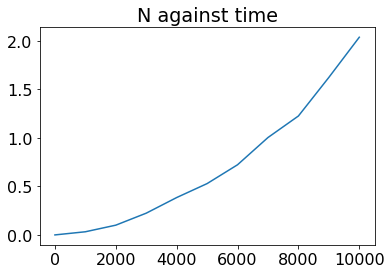

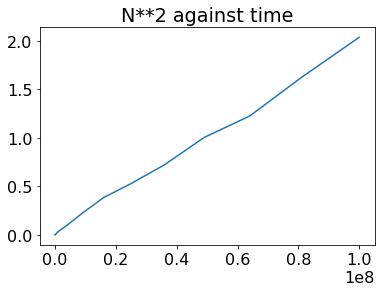

In [ ]:
times_N = np.zeros((1,2))
from time import perf_counter
for N in range(1000,11000,1000):
  start = perf_counter()

  rand = np.random.RandomState(0)

  u_times = rand.rand(N**2)
  results_times = np.empty_like(u_times)

  laplace_kernel[N**2,1](u_times,results_times)

  end = perf_counter()
  t = end - start

  times_N = np.append(times_N, [[N, t]], axis=0)


plt.figure()
plt.title("N against time")
plt.plot(times_N[:,0], times_N[:,1])
plt.figure()
plt.title("N**2 against time")
plt.plot(times_N[:,0]**2, times_N[:,1])

Here we see that indeed time follows a roughly linear relationship to N^2.

## Using shared memory to improve the memory behavior and reduce global memory accesses
We could speed this up by writing the  whole 1d array u into global memory, then splitting it into sub-arrays which are loaded into the shared memory. Then, we would evaluate laplacian for each of the shared arrays and then sum over them. Then it should be accessing just elements in the shared array rather than accessing the global memory to retrieve each element, because in our implementation there was no shared memory. So in the improved version each threadblock would now be responsible for computing a sub-array and each thread for one element of the sub array. We would divide the u input array into as many sub arrays of length threads-per-block as needed, then find the end result as sum of sub arrays. Each product is performed by first loading a sub array of u from global memory to shared memory, with one thread loading each element of each sub-array. Once sub array has been loaded, each thread accumulates the result into a register, then once all the products have been calculated, the results are written to the final result array in global memory. This reduces the number of global memory accesses since u is now only read u.shape[0]/TPB times, rather than reading from u multiple times for each calculation.